##**Car models classification.**

![PyTorch](https://img.shields.io/badge/PyTorch-EE4C2C?style=for-the-badge&logo=pytorch&logoColor=white) ![Python](https://img.shields.io/badge/python-3670A0?style=for-the-badge&logo=python&logoColor=ffdd54)  ![Colab](https://img.shields.io/badge/google_colaboratory-F9AB00?style=for-the-badge&logo=google-colab&logoColor=white)

Using  a light pre-trained MobileNetV2 with transfer learning to train the model. All layers will be fine tuned and the last fully connected layer will be replaced entirely.

**Code source: [haksorus_GitHub](https://github.com/haksorus/mobilenetv2-cars-classification/blob/main/mobilenetv2_training.ipynb)**

Original code was slightly modified.

**To get better accuracy we segment and crop cars with car_segment_with_yolo_2 script**

In [7]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# If you need dataset from Kaggle, download API key

from google.colab import files

files.upload()

In [ ]:
# Kaggle Authorization

# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle

# # Stanford car dataset with 196 models
# !kaggle datasets download -d eimadevyni/car-model-variants-and-images-dataset
# # !unzip /content/stanford-car-dataset-by-classes-folder.zip

# # Huge dataset with 3778 models
# !kaggle datasets download -d eimadevyni/car-model-variants-and-images-dataset?select=test

In [5]:
#All import in one

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random


import torch.nn as nn
import torch, torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torch import cuda

import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tqdm import tqdm, trange

In [8]:
TRAIN_PATH = "/content/drive/MyDrive/Segm_and_crop/train/"
TEST_PATH = "/content/drive/MyDrive/Segm_and_crop/test/"

In [9]:
# Every net requires specific size, mobilenet_v2 300*300

RESCALE_SIZE = 300
check_device = "cuda" if cuda.is_available() else "cpu"
DEVICE = torch.device(check_device) # Обучение на CPU будет длиться слишком долго, используем GPU
NCATS = len(os.listdir(TRAIN_PATH))

device(type='cpu')

In [10]:
def seed_worker(worker_id):
    np.random.seed(42)
    random.seed(42)

In [11]:
# ColorJitter improved accuracy
train_transforms = transforms.Compose([transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ColorJitter(hue=(-0.5, 0.5)),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


test_transforms = transforms.Compose([transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

#To use built-in ImageFolder, you should make folders named as label Acura_MDX for example, train -> Acura_MDX -> images
train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_PATH, transform = train_transforms)
test_dataset = torchvision.datasets.ImageFolder(root=TEST_PATH, transform = test_transforms)

In [12]:
# Load dataset

trainloader = DataLoader(train_dataset, batch_size = 32, shuffle=True, num_workers = 2, worker_init_fn=seed_worker)
testloader = DataLoader(test_dataset, batch_size = 32, shuffle=False, num_workers = 2, worker_init_fn=seed_worker)

In [13]:
#Helpfull functions to check the prapared dataset

def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow for tensors"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

def plot_loss(losses):
  """Train / val loss visualization"""
  sns.set(style="whitegrid", font_scale=1.4)
  plt.figure(figsize=(12, 8))
  plt.plot(losses['train'], label="train")
  plt.plot(losses['val'], label="val")
  plt.legend()
  plt.show()

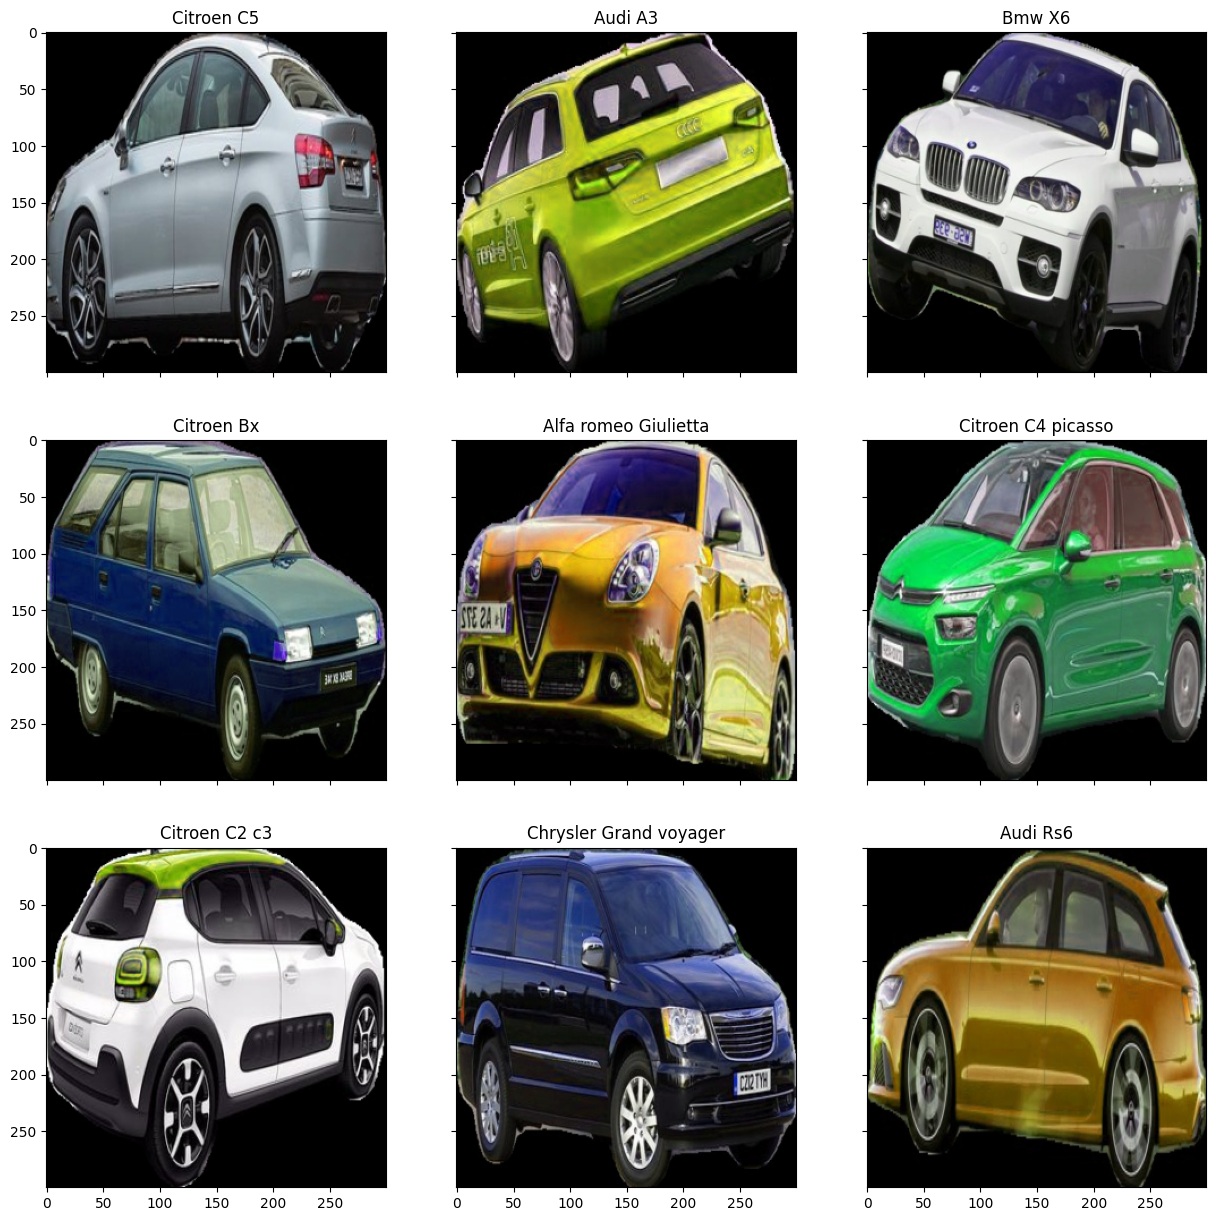

In [14]:
# Run this cell and make sure there are images in correct transformations

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(15, 15), \
                        sharey=True, sharex=True)

train_size = len(train_dataset)

label_encoder = LabelEncoder().fit(train_dataset.classes)

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, train_size))
    im_train, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(), str(label_encoder.inverse_transform([label])[0]).split('_')))
    plt.imshow(im_train.permute(1, 2, 0)  )
    imshow(im_train.data.cpu(), plt_ax=fig_x, title=img_label)

In [16]:
def train(train_loader, val_loader, model, num_epochs, optimizer, criterion, scheduler=None):

    best_model_wts = model.state_dict()
    best_epoch = 0
    best_score = 0


    losses = {'train': [], "val": []}

    pbar = trange(num_epochs, desc="Epoch:")

    loaders = {"train": train_loader, "val": val_loader}

    for epoch in pbar:

        for k, dataloader in loaders.items():

            running_loss = 0.0
            epoch_preds, epoch_batches = [], []

            for batch in tqdm(dataloader, leave=False, desc=f"{k} iter:"):
                x_batch, y_batch = batch
                x_batch = x_batch.to(DEVICE)
                y_batch = y_batch.to(DEVICE)
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)
                        loss = criterion(outp, y_batch)

                preds = outp.argmax(-1)

                epoch_preds += preds.cpu()
                epoch_batches += y_batch.cpu()
                running_loss += loss.item() * x_batch.size(0)

            epoch_score = accuracy_score(epoch_preds, epoch_batches)
            epoch_loss = running_loss / len(dataloader.dataset)
            losses[k].append(epoch_loss)



            if k == 'val':
              print(f'Epoch: {epoch + 1} of {num_epochs}  Score: {epoch_score}')
              if scheduler is not None:
                scheduler.step(epoch_loss)

            pbar.set_description('{} Loss: {:.4f} Score: {:.4f}'.format(k, epoch_loss, epoch_score))

            if k == 'val' and epoch_score > best_score:
               best_score = epoch_score
               best_epoch = epoch + 1
               best_model_wts = model.state_dict()



    print(f'Best score: {best_score}\nEpoch {best_epoch} of {num_epochs}')
    model.load_state_dict(best_model_wts)
    return model, losses, best_score

In [17]:
torch.cuda.empty_cache()

In [18]:
mob_netv2 = models.mobilenet_v2(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 323MB/s]


In [19]:
mob_netv2.classifier[1] = nn.Linear(in_features=mob_netv2.classifier[1].in_features, out_features=NCATS)

In [20]:
mob_netv2 = mob_netv2.to(DEVICE)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mob_netv2.parameters(), lr=1e-4, weight_decay = 1e-5)

mob_netv2, losses_mob_netv2, accuracy_mob_netv2 = train(trainloader, testloader, model=mob_netv2, num_epochs=25, optimizer=optimizer, criterion=criterion)

In [ ]:
torch.save(mob_netv2.state_dict(), '/content/drive/MyDrive/state_dict_mob_netv2_90_perc.pth')
torch.save(mob_netv2, '/content/drive/MyDrive/model_mob_netv2_90_perc.pth')

In [23]:
from torchsummary import summary

model = mob_netv2
summary(model, (3, 300, 300))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 150, 150]             864
       BatchNorm2d-2         [-1, 32, 150, 150]              64
             ReLU6-3         [-1, 32, 150, 150]               0
            Conv2d-4         [-1, 32, 150, 150]             288
       BatchNorm2d-5         [-1, 32, 150, 150]              64
             ReLU6-6         [-1, 32, 150, 150]               0
            Conv2d-7         [-1, 16, 150, 150]             512
       BatchNorm2d-8         [-1, 16, 150, 150]              32
  InvertedResidual-9         [-1, 16, 150, 150]               0
           Conv2d-10         [-1, 96, 150, 150]           1,536
      BatchNorm2d-11         [-1, 96, 150, 150]             192
            ReLU6-12         [-1, 96, 150, 150]               0
           Conv2d-13           [-1, 96, 75, 75]             864
      BatchNorm2d-14           [-1, 96,

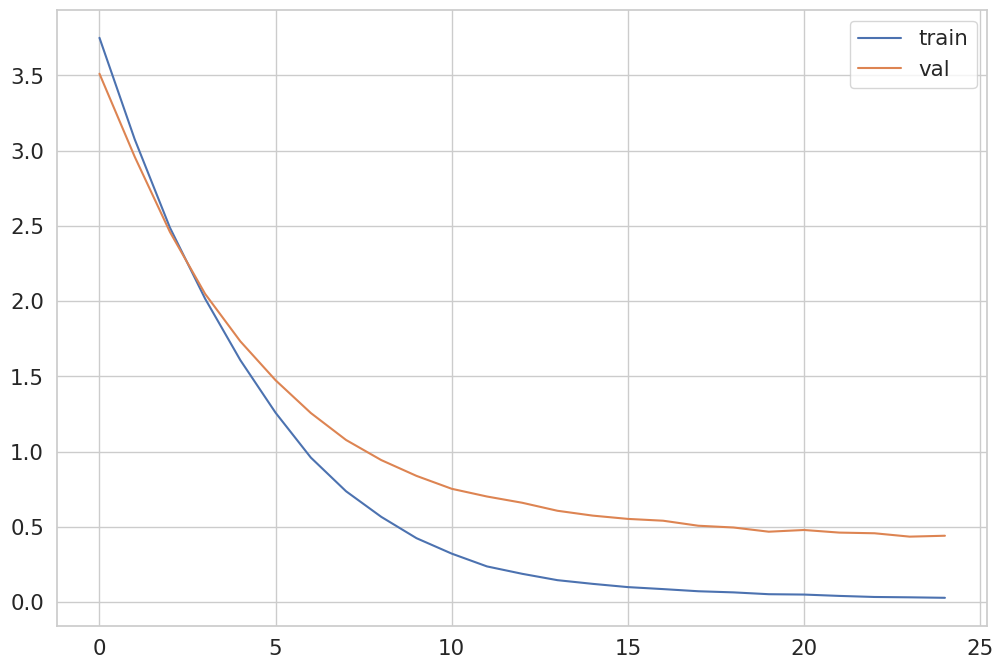

In [ ]:
plot_loss(losses_mob_netv2)

In [30]:
#predict labels VS original, don't use here images from train dataset, better not to use from test either, the best will be to use on new dataset, but segmented and cropped

predict_dataset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/Segm_and_crop/test/', transform=test_transforms)

In [32]:
predict_loader= DataLoader(predict_dataset, batch_size=32, shuffle=True)

In [33]:
preds_all = []

model =  models.mobilenet_v2()
model.classifier[1] = nn.Linear(in_features=mob_netv2.classifier[1].in_features, out_features=NCATS)
model.load_state_dict(torch.load('/content/drive/MyDrive/state_dict_mob_netv2_90_perc.pth', map_location=torch.device('cpu')))
model.eval()

real_labels = []
for batch in tqdm(predict_loader, leave=False):
    x_batch, y_batch = batch
    outp = model(x_batch)
    real_labels.append(y_batch)
    preds_all.append(outp.argmax(-1))

preds_all
real_labels


[tensor([10, 66, 29, 29, 51, 51, 18, 56,  7, 46, 57, 51, 24,  1, 44, 20,  3, 32,
         13,  8, 18, 51, 14, 52, 14, 63, 62, 28, 19, 21, 72, 14]),
 tensor([ 2, 53, 58, 24, 25, 67, 65, 70, 62, 12, 37, 26, 47,  9, 20, 30, 47, 52,
          4, 17, 31, 65, 74,  6,  0, 34, 16,  0, 36, 42, 21,  4]),
 tensor([11, 25, 52, 22, 69, 14, 45, 61, 19, 54, 60, 59, 70, 48, 38, 60, 64, 53,
          5, 20,  3, 48,  3, 73, 66, 21, 31, 12, 12, 37, 61, 71]),
 tensor([50, 23, 37, 71, 23,  6,  3, 66,  0,  7, 44, 38, 30,  6, 60, 11,  1,  8,
         38, 59, 17, 64, 22, 41, 69, 68, 16, 51, 23, 54, 26, 57]),
 tensor([49, 26, 30, 12, 27, 65, 64, 43, 50,  5, 58, 54, 53, 27, 38, 68, 13, 56,
         31, 30, 28, 33, 16, 74, 32, 17, 48, 49, 58, 53, 56, 41]),
 tensor([ 4, 31,  1, 14, 49, 24, 68, 55, 65, 11, 42,  9,  8, 42, 45, 40,  2, 15,
         37, 39, 67, 22, 35, 63, 70, 33, 71, 55,  6,  5, 13, 66]),
 tensor([53, 50, 41, 68, 71, 62, 33, 63, 43, 13, 20, 32, 39,  7, 42, 48, 73, 72,
         33, 36,  7, 59, 28, 43

In [34]:
answers = []
for i in preds_all:
  answers += i.tolist()

labels = []
for i in real_labels:
  labels += i.tolist()

count = 0
for i in range(len(answers)):
  if labels[i] == answers[i]:
    count += 1

good_work = count / len(answers) * 100

good_work

90.87837837837837